In [1]:
import os
import pandas as pd
import numpy as np
import sns
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [3]:


os.environ["JAVA_HOME"] = r"C:/Program Files/Eclipse Adoptium/jdk-17.0.15.6-hotspot/"

CSV_PATH = 'D:/projeto_lapes/datalake/gold/paciente_gold.parquet'
IMAGES_DIR = 'D:/projeto_lapes/data/chest_x-ray/images'


In [4]:
IMAGE_SIZE = (128, 128)
NUM_IMAGES = 50000  # limite para teste rápido (você pode aumentar depois)


In [5]:
df = pd.read_parquet(CSV_PATH)
df = df.head(NUM_IMAGES)

In [6]:
df['patologias'] = df['doencas'].apply(lambda x: x.split('|'))
# 2. Binarizar
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['patologias'])

print("Classes:", mlb.classes_)

Classes: ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [7]:
def process_image(img_name):
    path = os.path.join(IMAGES_DIR, img_name)
    try:
        with Image.open(path).convert('L') as img:  # grayscale
            img = img.resize(IMAGE_SIZE)
            return np.array(img).flatten()
    except:
        return None

X = []
valid_y = []

print("Carregando imagens...")
for i, row in tqdm(df.iterrows(), total=len(df)):
    features = process_image(row['index_da_imagem'])
    if features is not None:
        X.append(features)
        valid_y.append(y[i])

X = np.array(X)
y = np.array(valid_y)

Carregando imagens...


100%|██████████| 50000/50000 [07:33<00:00, 110.14it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo de regressão logística multilabel
logreg = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver='saga' ,n_jobs=-1),
    n_jobs=-1)

print("Treinando modelo de regressão logística...")
logreg.fit(X_train, y_train)

# Previsões
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)

# Métricas por classe
print("Relatório de classificação:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# AUC por classe
print("AUC-ROC por classe:")
for i, class_name in enumerate(mlb.classes_):
    try:
        auc = roc_auc_score(y_test[:, i], y_prob[:, i])
        print(f"{class_name}: {auc:.4f}")
    except ValueError:
        print(f"{class_name}: AUC não calculável (classe ausente no y_test)")


Treinando modelo de regressão logística...


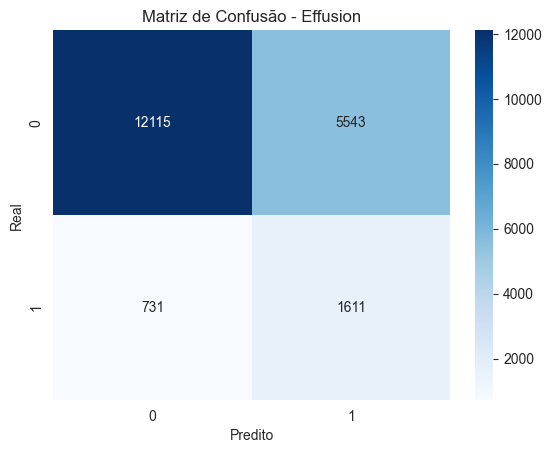

In [64]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_idx = list(mlb.classes_).index("Effusion")
cm = confusion_matrix(y_test[:, label_idx], y_pred[:, label_idx])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Effusion")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


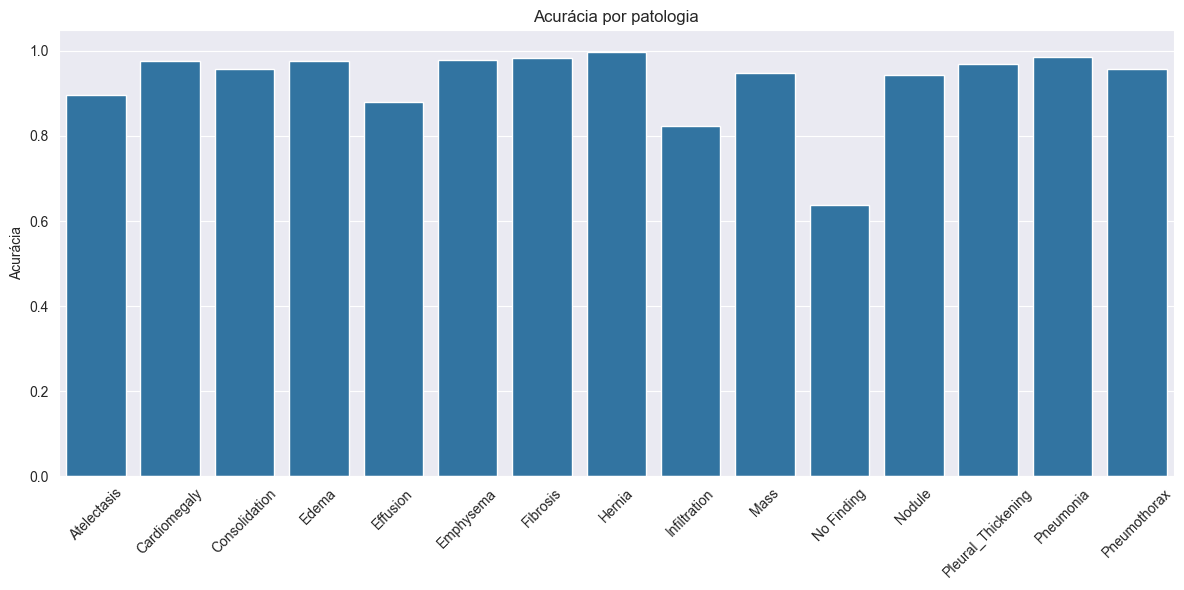

In [68]:
from sklearn.metrics import accuracy_score

accs = []
for i in range(y.shape[1]):
    acc = accuracy_score(y_test[:, i], y_pred[:, i])
    accs.append(acc)

plt.figure(figsize=(12, 6))
sns.barplot(x=mlb.classes_, y=accs)
plt.xticks(rotation=45)
plt.ylabel("Acurácia")
plt.title("Acurácia por patologia")
plt.tight_layout()
plt.show()

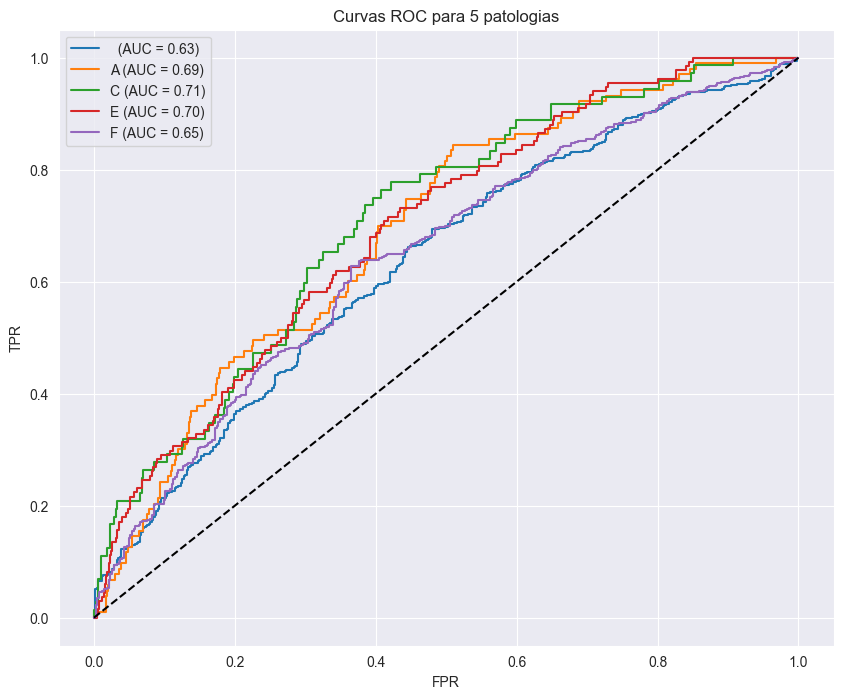

In [19]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for i, label in enumerate(mlb.classes_[:5]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[i][:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC para 5 patologias")
plt.legend()
plt.show()